In [1]:
# Load the library
import pandas as pd
import numpy as np
import os, shutil
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from keras.applications import VGG16
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [8]:
# # The path to the directory where the original
# # dataset was uncompressed
original_dataset_dir = 'C:/Users/liulu/Downloads/image_2'

In [6]:
# # The directory where we will
# # store our smaller dataset
base_dir = 'C:/Users/liulu/Downloads/Test'
os.mkdir(base_dir)

In [7]:
# # Directories for our training,
# # validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

In [11]:
# # Directory with our training pub pictures
train_pub_dir = os.path.join(train_dir, 'pub')
os.mkdir(train_pub_dir)

# # Directory with our training priv pictures
train_priv_dir = os.path.join(train_dir, 'priv')
os.mkdir(train_priv_dir)

# # Directory with our validation pub pictures
validation_pub_dir = os.path.join(validation_dir, 'pub')
os.mkdir(validation_pub_dir)

# # Directory with our validation priv pictures
validation_priv_dir = os.path.join(validation_dir, 'priv')
os.mkdir(validation_priv_dir)

# # Directory with our test bar pictures
test_pub_dir = os.path.join(test_dir, 'pub')
os.mkdir(test_pub_dir)

# # Directory with our test bedroom pictures
test_priv_dir = os.path.join(test_dir, 'priv')
os.mkdir(test_priv_dir)

In [13]:
# Copy first 4000 public images to train_bar_dir
fnames = ['pub{}.jpg'.format(i) for i in range(1,4001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_pub_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 1000 public images to validation_bar_dir
fnames = ['pub{}.jpg'.format(i) for i in range(4001, 5001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_pub_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 public images to test_bar_dir
fnames = ['pub{}.jpg'.format(i) for i in range(5001, 6001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_pub_dir, fname)
    shutil.copyfile(src, dst)

In [14]:
# Copy first 2000 private images to train_bedroom_dir
fnames = ['priv{}.jpg'.format(i) for i in range(1,2001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_priv_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 private images to validation_bedroom_dir
fnames = ['priv{}.jpg'.format(i) for i in range(2001, 3001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_priv_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 1000 private images to test_bedroom_dir
fnames = ['priv{}.jpg'.format(i) for i in range(3001, 4001)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_priv_dir, fname)
    shutil.copyfile(src, dst)

In [16]:
# Sanity checks
print('total training public images:',len(os.listdir(train_pub_dir)))
print('total training private images:',len(os.listdir(train_priv_dir)))
print('total validation public images:',len(os.listdir(validation_pub_dir)))
print('total validation private images:',len(os.listdir(validation_priv_dir)))
print('total test public images:', len(os.listdir(test_pub_dir)))
print('total test private images:', len(os.listdir(test_priv_dir)))

total training public images: 4000
total training private images: 2000
total validation public images: 1000
total validation private images: 1000
total test public images: 1000
total test private images: 1000


In [18]:
# use pre-trained model as feature extractor

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150,150,3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [19]:
# Extract features
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):

    features = np.zeros(shape=(sample_count, 4, 4, 512)) # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))

    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150,150),
                                            batch_size = batch_size,class_mode='binary')

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [20]:
# get features
train_features, train_labels = extract_features(train_dir, 6000)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 2000)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [21]:
# Define model
epochs = 100
model = Sequential()
model.add(Flatten(input_shape=(4,4,512)))
model.add(Dense(256, activation='relu', input_dim=(4*4*512)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train model using features extracted
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.4131 - acc: 0.8147 - val_loss: 0.6597 - val_acc: 0.6810
Epoch 2/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.3020 - acc: 0.8693 - val_loss: 0.7660 - val_acc: 0.6645
Epoch 3/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.2575 - acc: 0.8913 - val_loss: 0.6572 - val_acc: 0.7015
Epoch 4/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.2221 - acc: 0.9055 - val_loss: 0.7649 - val_acc: 0.6975
Epoch 5/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.1997 - acc: 0.9147 - val_loss: 0.8485 - val_acc: 0.6970
Epoch 6/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.1653 - acc: 0.9327 - val_loss: 0.7422 - val_acc: 0.7125
Epoch 7/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.1507 - acc: 0.9413 - val_loss: 0.8722 - val_acc: 0.6800
Epoch 8

Epoch 61/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0243 - acc: 0.9925 - val_loss: 2.4215 - val_acc: 0.7070
Epoch 62/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0219 - acc: 0.9917 - val_loss: 2.2456 - val_acc: 0.7020
Epoch 63/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0246 - acc: 0.9910 - val_loss: 1.8374 - val_acc: 0.7095
Epoch 64/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0287 - acc: 0.9882 - val_loss: 2.1307 - val_acc: 0.7045
Epoch 65/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0194 - acc: 0.9927 - val_loss: 2.6836 - val_acc: 0.6920
Epoch 66/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0258 - acc: 0.9900 - val_loss: 2.5554 - val_acc: 0.6890
Epoch 67/100
6000/6000 [==============================] - 7s 1ms/step - loss: 0.0153 - acc: 0.9937 - val_loss: 2.5692 - val_acc: 0.7045
Epoch 68/100
6000/6000 [========================

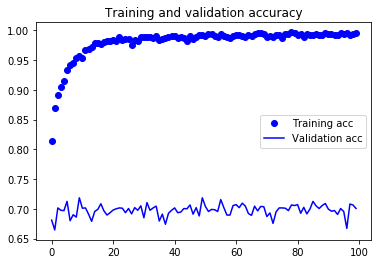

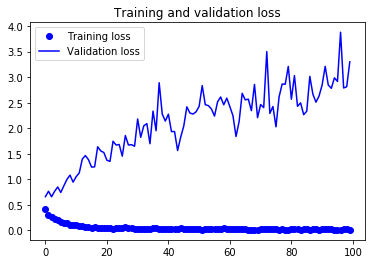

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Obviously, the model is overfitting because there is a far distance between training curve and validation curve.

In [25]:
test_predict=model.predict(test_features)
score = accuracy_score(test_labels, test_predict.round())
print("The accruacy score is %f" % score)

The accruacy score is 0.711000


* In order to compare the result with different methods, this time I add a global average pooling layer.

In [26]:
# Define model

epochs = 100
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(4,4,512)))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train model
history = model.fit(train_features, 
                    train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 6000 samples, validate on 2000 samples
Epoch 1/100
6000/6000 [==============================] - 1s 212us/step - loss: 0.5432 - acc: 0.7032 - val_loss: 0.7040 - val_acc: 0.5345
Epoch 2/100
6000/6000 [==============================] - 1s 202us/step - loss: 0.4538 - acc: 0.7948 - val_loss: 0.6876 - val_acc: 0.5705
Epoch 3/100
6000/6000 [==============================] - 1s 182us/step - loss: 0.4158 - acc: 0.8122 - val_loss: 0.6561 - val_acc: 0.6115
Epoch 4/100
6000/6000 [==============================] - 1s 169us/step - loss: 0.3940 - acc: 0.8227 - val_loss: 0.6488 - val_acc: 0.6260
Epoch 5/100
6000/6000 [==============================] - 1s 171us/step - loss: 0.3781 - acc: 0.8307 - val_loss: 0.6534 - val_acc: 0.6290
Epoch 6/100
6000/6000 [==============================] - 1s 174us/step - loss: 0.3662 - acc: 0.8412 - val_loss: 0.6381 - val_acc: 0.6465
Epoch 7/100
6000/6000 [==============================] - 1s 172us/step - loss: 0.3577 - acc: 0.8430 - val_loss: 0.6769 - val_acc: 

6000/6000 [==============================] - 1s 191us/step - loss: 0.2668 - acc: 0.8842 - val_loss: 0.6953 - val_acc: 0.6900
Epoch 61/100
6000/6000 [==============================] - 1s 195us/step - loss: 0.2672 - acc: 0.8843 - val_loss: 0.7096 - val_acc: 0.6885
Epoch 62/100
6000/6000 [==============================] - 1s 206us/step - loss: 0.2662 - acc: 0.8832 - val_loss: 0.6959 - val_acc: 0.6890
Epoch 63/100
6000/6000 [==============================] - 1s 184us/step - loss: 0.2653 - acc: 0.8845 - val_loss: 0.6988 - val_acc: 0.6915
Epoch 64/100
6000/6000 [==============================] - 1s 164us/step - loss: 0.2652 - acc: 0.8848 - val_loss: 0.6758 - val_acc: 0.6950
Epoch 65/100
6000/6000 [==============================] - 1s 178us/step - loss: 0.2640 - acc: 0.8857 - val_loss: 0.6617 - val_acc: 0.6955
Epoch 66/100
6000/6000 [==============================] - 1s 163us/step - loss: 0.2640 - acc: 0.8842 - val_loss: 0.6815 - val_acc: 0.6925
Epoch 67/100
6000/6000 [=======================

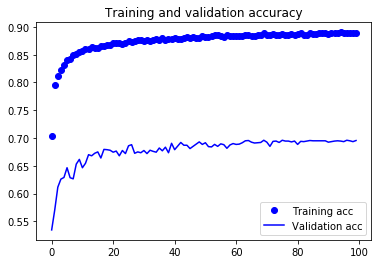

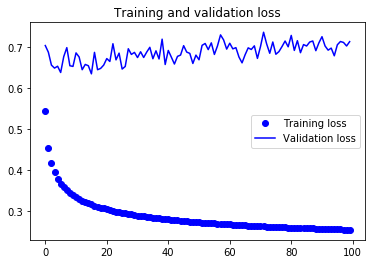

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
test_predict=model.predict(test_features)
score = accuracy_score(test_labels, test_predict.round())
print("The accruacy score is %f" % score)

The accruacy score is 0.733500


In [62]:
# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


In [ ]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
first_layer_activation = activations[0]
print(first_layer_activation.shape)

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
 

def get_row_col(num_pic):
    squr = num_pic ** 0.5
    row = round(squr)
    col = row + 1 if squr - row > 0 else row
    return row, col
 

def visualize_feature_map(img_batch):
    feature_map = img_batch
    print(feature_map.shape)
 
    feature_map_combination = []
    plt.figure()
 
    num_pic = feature_map.shape[2]
    row, col = get_row_col(num_pic)
 
    for i in range(0, num_pic):
        feature_map_split = feature_map[:, :, i]
        feature_map_combination.append(feature_map_split)
        plt.subplot(row, col, i + 1)
        plt.imshow(feature_map_split)
        axis('off')
 
    plt.savefig('feature_map.png')
    plt.show()

    feature_map_sum = sum(ele for ele in feature_map_combination)
    plt.imshow(feature_map_sum)
    plt.savefig("feature_map_sum.png")


(1, 4, 4, 512)
(4, 4, 512)


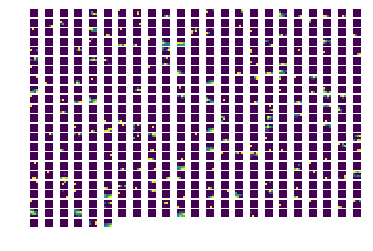

C:\Users\liulu\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


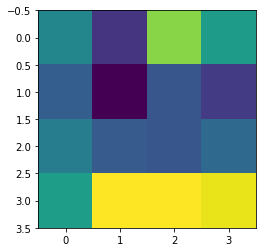

In [67]:
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block1_pool').output)
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_pool').output)
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block3_pool').output)
# model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
model = Model(inputs=conv_base.input, outputs=conv_base.get_layer('block5_pool').output)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
block_pool_features = model.predict(x)
print(block_pool_features.shape)

feature = block_pool_features.reshape(block_pool_features.shape[1:])

visualize_feature_map(feature)


* Train svm classifier using features extracted

In [30]:
# Concatenate training and validation sets
svm_features = np.concatenate((train_features, 
                               validation_features))

svm_labels = np.concatenate((train_labels, 
                             validation_labels))

In [32]:
# Build model
X_train, y_train = svm_features.reshape(8000,4*4*512), svm_labels
param = [{"C": [0.01, 0.1, 1, 10, 100]}]
svm = LinearSVC(penalty='l2', loss='squared_hinge')
clf = GridSearchCV(svm, param, cv=10)

In [33]:
clf.fit(X_train, y_train)

C:\Users\liulu\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\liulu\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\liulu\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\liulu\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\liulu\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [35]:
test_predict=clf.predict(test_features.reshape(2000,4*4*512))
score = accuracy_score(test_labels, test_predict)
print("The accruacy score is %f" % score)

The accruacy score is 0.742000


* Reduce overfitting by using generator

In [69]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [70]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 150, 150, 3)
labels batch shape: (32,)


In [74]:
from keras import models
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [73]:
conv_base.trainable = False

In [75]:
# Compile model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train model using generator 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 486s 5s/step - loss: 0.4842 - acc: 0.7864 - val_loss: 1.0587 - val_acc: 0.5819
Epoch 2/100
100/100 [==============================] - 550s 5s/step - loss: 0.3069 - acc: 0.8681 - val_loss: 0.7238 - val_acc: 0.6970
Epoch 3/100
100/100 [==============================] - 586s 6s/step - loss: 0.2403 - acc: 0.8997 - val_loss: 0.4637 - val_acc: 0.6711
Epoch 4/100
100/100 [==============================] - 584s 6s/step - loss: 0.2450 - acc: 0.8967 - val_loss: 1.0830 - val_acc: 0.7039
Epoch 5/100
100/100 [==============================] - 612s 6s/step - loss: 0.1792 - acc: 0.9300 - val_loss: 0.5259 - val_acc: 0.7150
Epoch 6/100
100/100 [==============================] - 613s 6s/step - loss: 0.1826 - acc: 0.9269 - val_loss: 1.2042 - val_acc: 0.6806
Epoch 7/100
100/100 [==============================] - 662s 7s/step - loss: 0.1386 - acc: 0.9460 - val_loss: 0.6219 - val_acc: 0.7008
Epoch 8/100
100/100 [==============================] - 709s 7s

Epoch 61/100
100/100 [==============================] - 534s 5s/step - loss: 1.0533e-04 - acc: 1.0000 - val_loss: 2.8373 - val_acc: 0.6944
Epoch 62/100
100/100 [==============================] - 526s 5s/step - loss: 1.0582e-04 - acc: 1.0000 - val_loss: 2.3140 - val_acc: 0.6818
Epoch 63/100
100/100 [==============================] - 534s 5s/step - loss: 9.2109e-05 - acc: 1.0000 - val_loss: 4.7564 - val_acc: 0.6806
Epoch 64/100
100/100 [==============================] - 541s 5s/step - loss: 9.4191e-05 - acc: 1.0000 - val_loss: 2.5068 - val_acc: 0.6712
Epoch 65/100
100/100 [==============================] - 539s 5s/step - loss: 8.7413e-05 - acc: 1.0000 - val_loss: 3.3919 - val_acc: 0.6944
Epoch 66/100
100/100 [==============================] - 526s 5s/step - loss: 7.3310e-05 - acc: 1.0000 - val_loss: 3.5365 - val_acc: 0.6976
Epoch 67/100
100/100 [==============================] - 547s 5s/step - loss: 7.3242e-05 - acc: 1.0000 - val_loss: 3.9914 - val_acc: 0.6736
Epoch 68/100
100/100 [=====

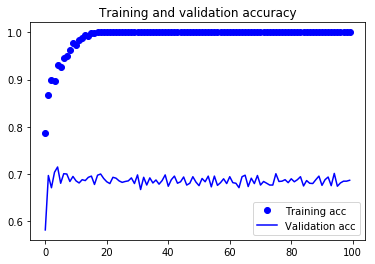

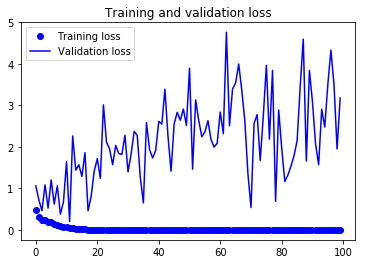

In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [77]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 2000 images belonging to 2 classes.
test acc: 0.703000009059906
